Importing Neccesary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import zipfile
import os, os.path

Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split-20240703T015611Z-001.zip', 'r')
zip_ref.extractall('/content/Raw_Data_v2')
zip_ref.close()

Exploratory Data Analysis

In [4]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/Raw_Data.zip'
extract_path = '/content/drive/MyDrive/Colab Notebooks/Raw_Data/'

#Unzipping folder
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #zip_ref.extractall(extract_path)

#Defining path to access each class folder
subdir_path = os.path.join(extract_path, "Raw_Data")
subdir_list = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

#Function to count the number of images
def count_images(directory):
    return len([name for name in os.listdir(directory)
                if os.path.isfile(os.path.join(directory, name)) and
                name.lower().endswith(('.png', '.jpg', '.jpeg'))])

#Loop through each class, print number of images and total number of images
tot_images = 0
for subfolder in subdir_list:
    subfolder_path = os.path.join(subdir_path, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = count_images(subfolder_path)
        tot_images += num_images
        print(f"Number of images in '{subfolder}': {num_images}")
print(f"Total number of images: {tot_images}")

Number of images in 'glioma_tumor': 2547
Number of images in 'meningioma_tumor': 2582
Number of images in 'no_tumor': 2396
Number of images in 'pituitary_tumor': 2658
Total number of images: 10183


In [5]:
#!pip install split_folders

In [6]:
#import splitfolders
#splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/Raw_Data/Raw_Data', '/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split',seed=999, ratio=(.6,.2,.2))

In [7]:
split_list = ['train', 'val', 'test']
subdir_path = '/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split'

tot_images = 0
for split in split_list:
    split_path = os.path.join(subdir_path, split)
    if os.path.isdir(split_path):
        print(f"{split} set image distribution:")
        for class_folder in subdir_list:
            class_folder_path = os.path.join(split_path, class_folder)
            if os.path.isdir(class_folder_path):
                num_images = count_images(class_folder_path)
                tot_images += num_images
                print(f"  Number of images in class '{class_folder}': {num_images}")
print(f"Total number of images: {tot_images}")

train set image distribution:
  Number of images in class 'glioma_tumor': 1528
  Number of images in class 'meningioma_tumor': 1549
  Number of images in class 'no_tumor': 1437
  Number of images in class 'pituitary_tumor': 1594
val set image distribution:
  Number of images in class 'glioma_tumor': 509
  Number of images in class 'meningioma_tumor': 516
  Number of images in class 'no_tumor': 479
  Number of images in class 'pituitary_tumor': 531
test set image distribution:
  Number of images in class 'glioma_tumor': 510
  Number of images in class 'meningioma_tumor': 517
  Number of images in class 'no_tumor': 480
  Number of images in class 'pituitary_tumor': 533
Total number of images: 10183


Image Augmentation and DataLoader creation

In [8]:
# randomly changing color intensity in each image by a constant value

folder_path = '/content/Raw_Data_v2/Raw_Data_Split/train'

for Class in ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']:
  class_path = os.path.join(folder_path, Class)

  # List contents of the folder
  contents = os.listdir(class_path)

  for img_name in contents:
    img_path = os.path.join(class_path, img_name)
    img = plt.imread(img_path)

    random_num = np.random.randint(0,1)
    if(random_num < 0.5):
      img = img/255
      img = np.clip((img + 0.25), 0, 1)

In [9]:
def create_loaders(batch_size):

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize((0.5), (0.5))
                                    ])

    augment = transforms.Compose([transforms.ToTensor(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize((0.5), (0.5)),
                                    transforms.RandomRotation(45),
                                    transforms.GaussianBlur(5, (0.1,2))
                                    ])



    #Create Datasets for each set and apply transformation to training dataset
    train_dataset = datasets.ImageFolder(root='/content/Raw_Data_v2/Raw_Data_Split/train', transform=augment)
    val_dataset = datasets.ImageFolder(root='/content/Raw_Data_v2/Raw_Data_Split/val', transform = transform)
    test_dataset = datasets.ImageFolder(root='/content/Raw_Data_v2/Raw_Data_Split/test', transform = transform)


    #Create DataLoaders for each set
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader

Modified ResNet

In [10]:
# Load pre-trained model and modify the final layer
from torchvision import models
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1 channel instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final layer to have 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 classes

def freeze_layers(model):
    layers = list(model.children())
    num_layers_to_freeze = len(layers) // 2

    for i in range(num_layers_to_freeze):
        for param in layers[i].parameters():
            param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 59.8MB/s]


In [11]:
!nvidia-smi

Mon Aug 12 15:51:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [13]:
train_loader, val_loader, test_loader = create_loaders(128)

Accuracy and Train functions

In [14]:
def get_accuracy(model, train_loader, val_loader, train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Epoch loss: 0.006883579771965742 Train acc: 0.6337590045841519 Validation acc: 0.6383292383292384
Epoch loss: 0.006549532059580088 Train acc: 0.7480353634577603 Validation acc: 0.7184275184275184
Epoch loss: 0.0063461195677518845 Train acc: 0.747871643745907 Validation acc: 0.711056511056511
Epoch loss: 0.004709077067673206 Train acc: 0.8113948919449901 Validation acc: 0.8103194103194103
Epoch loss: 0.00491692777723074 Train acc: 0.8544531761624099 Validation acc: 0.8191646191646191
Epoch loss: 0.0032891943119466305 Train acc: 0.8813032089063523 Validation acc: 0.8653562653562653
Epoch loss: 0.0017165086464956403 Train acc: 0.8842501637197119 Validation acc: 0.8727272727272727
Epoch loss: 0.0013186376309022307 Train acc: 0.8655861165684349 Validation acc: 0.8113022113022113
Epoch loss: 0.003236050484701991 Train acc: 0.9007858546168959 Validation acc: 0.8697788697788698
Epoch loss: 0.001607484184205532 Train acc: 0.899803536345776 Validation acc: 0.8815724815724816
Epoch loss: 0.001284

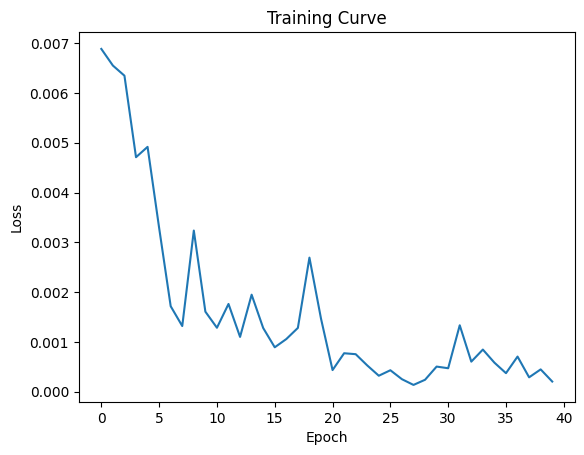

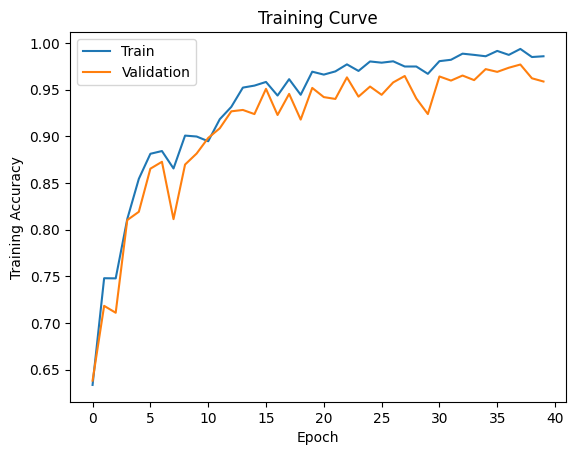

Final Training Accuracy: 0.9857563850687623
Final Validation Accuracy: 0.9587223587223587


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs, losses, train_acc, val_acc = [], [], [], []

num_epochs = 40
batch_size = 128

# training
n = 0 # the number of iterations
for epoch in range(num_epochs):
    for imgs, labels in iter(train_loader):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################

        out = model(imgs)             # forward pass

        loss = criterion(out, labels) # compute the total loss
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
    epochs.append(n)
    losses.append(float(loss)/batch_size)             # compute *average* loss
    train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy
    val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
    n += 1
    print("Epoch loss: {} Train acc: {} Validation acc: {}".format(losses[-1], train_acc[-1], val_acc[-1]))

# plotting
plt.title("Training Curve")
plt.plot(epochs, losses, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.title("Training Curve")
plt.plot(epochs, train_acc, label="Train")
plt.plot(epochs, val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))
torch.save(model.state_dict(), 'brain_tumor_model2.pth')

Test function that also computes confusion matrix

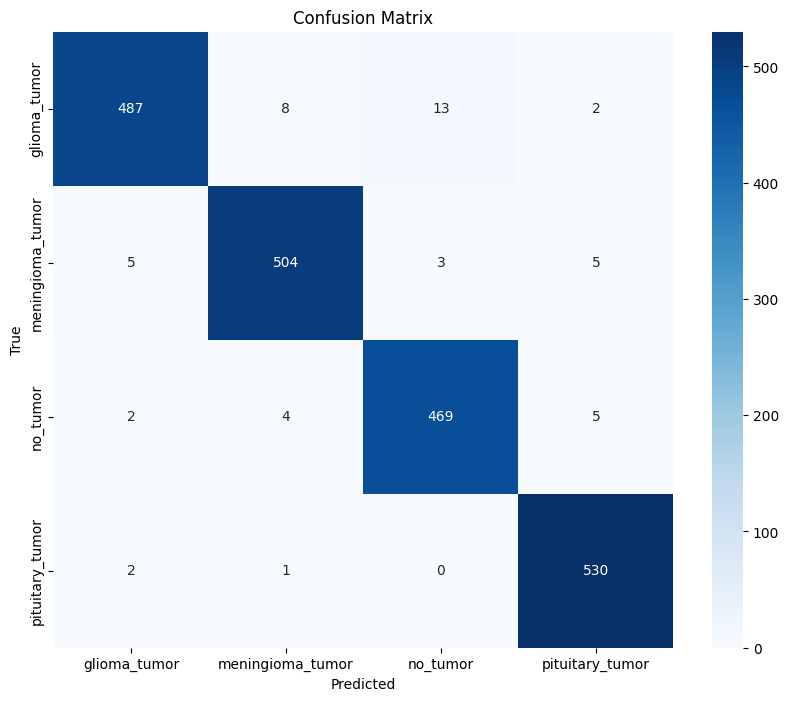

Accuracy: 0.9755


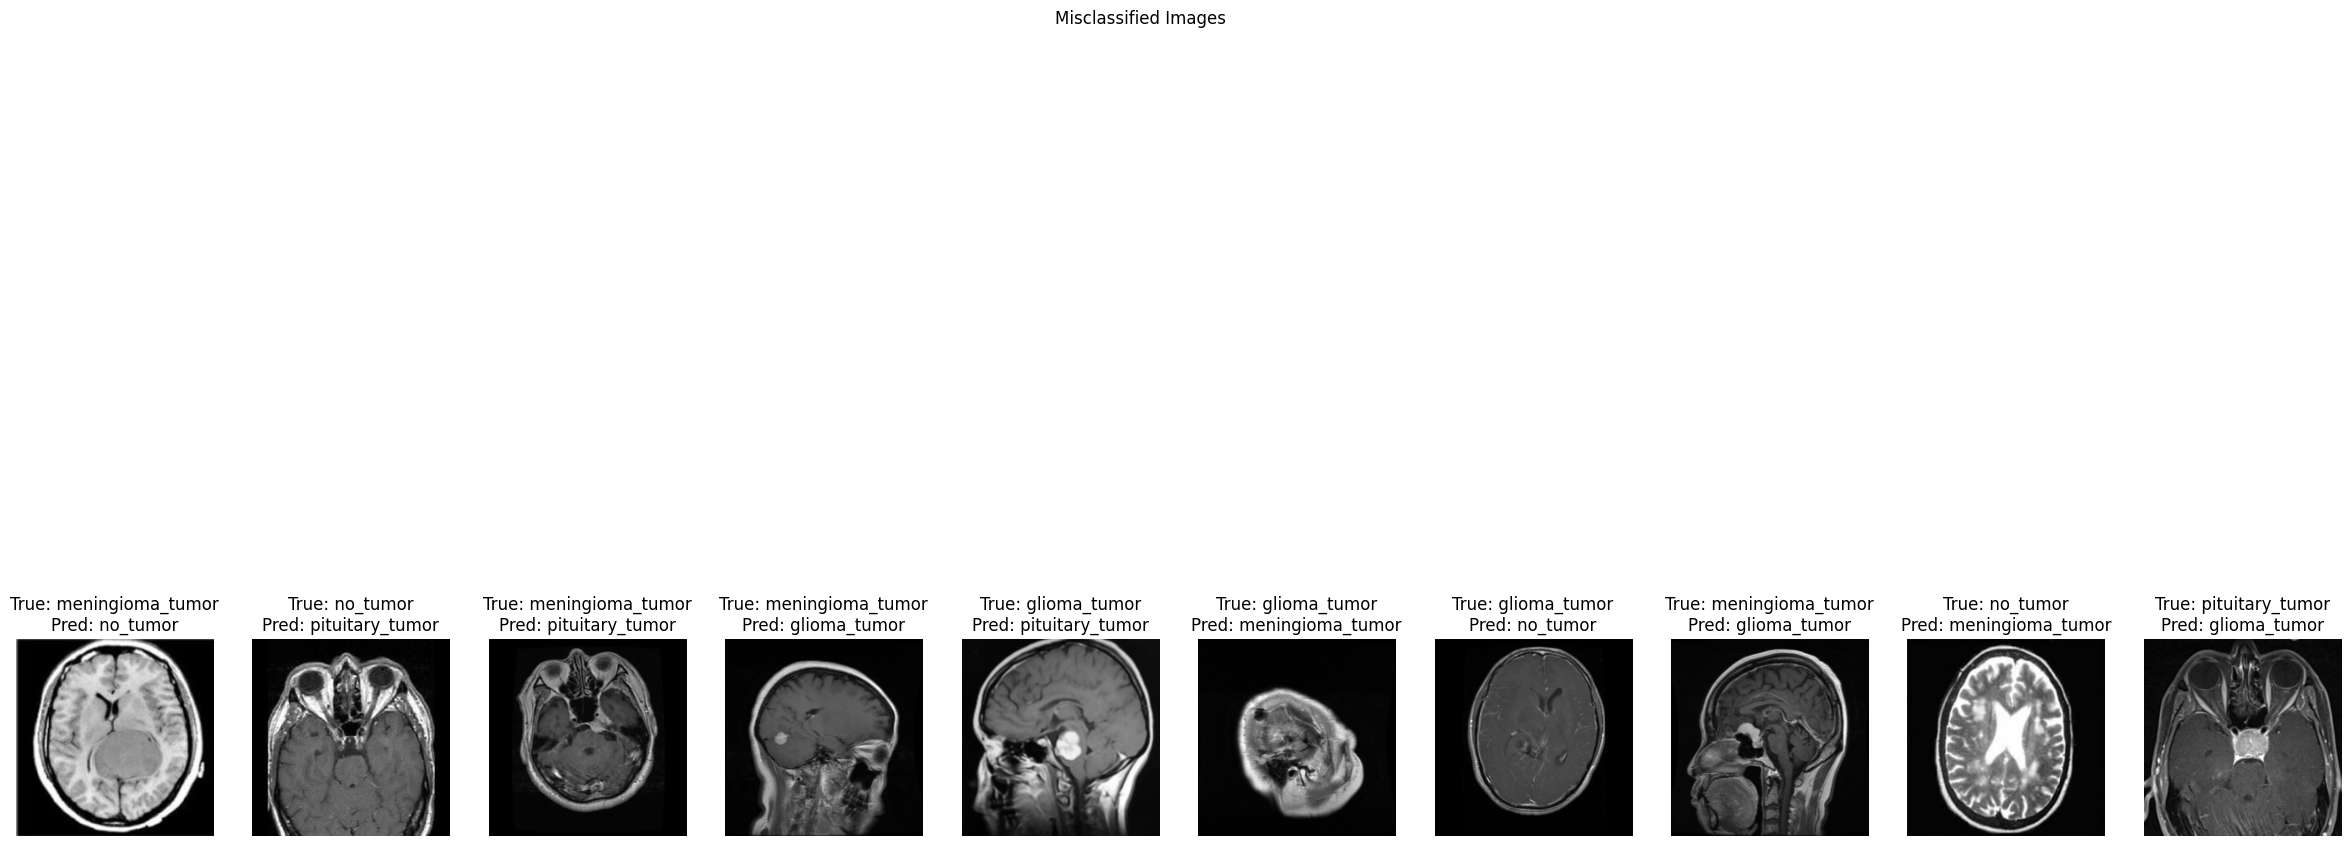

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_accuracy_test(model, test_loader):
    model.load_state_dict(torch.load('brain_tumor_model2.pth'))
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    misclassified_images = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################

            output = model(imgs)

            # Select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]

            # Store predictions and labels for confusion matrix
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            misclassified_images.extend([(img.cpu(), label.cpu(), p.cpu()) for img, label, p in zip(imgs, labels, pred) if label != p])

    accuracy = correct / total

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, misclassified_images

def show_misclassified_images(misclassified, classes, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(30, 15))
    fig.suptitle('Misclassified Images')
    for i, (img, true_label, pred_label) in enumerate(misclassified[:num_images]):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f'True: {classes[true_label.item()]}\nPred: {classes[pred_label.item()]}')
        axes[i].axis('off')
    plt.show()

# Assuming test_loader is already defined and loaded with your test data
accuracy, misclassified = get_accuracy_test(model, test_loader)
print(f'Accuracy: {accuracy:.4f}')

# Assuming test_loader.dataset.classes contains the class names
show_misclassified_images(misclassified, test_loader.dataset.classes)


NEW DATASET

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/brain_tumor_test_set NEW.zip', 'r')
zip_ref.extractall('/content/NewClassificationData')
zip_ref.close()

In [19]:
!pip install split_folders

In [29]:
import splitfolders
splitfolders.ratio('/content/NewClassificationData/', '/content/NewClassificationData_ForTesting',seed=999, ratio=(0,0,1))

Copying files: 800 files [00:00, 6753.94 files/s]


In [33]:
import os
import random
from shutil import move

def truncate_to_fixed_size(data_dir, output_dir, target_count=250):
    # Step 1: Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Step 2: Truncate each class to the target number of images
    class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(data_dir, class_dir)
        output_class_path = os.path.join(output_dir, class_dir)
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        images = os.listdir(class_path)
        random.shuffle(images)

        # Keep only the first 'target_count' images
        for img in images[:target_count]:
            move(os.path.join(class_path, img), os.path.join(output_class_path, img))

    print(f"Truncated all classes to {target_count} images each.")

# Example usage
data_directory = '/content/NewClassificationData_ForTesting/test'
output_directory = '/content/TruncatedClassificationData'
truncate_to_fixed_size(data_directory, output_directory, target_count=200)


Truncated all classes to 200 images each.


In [34]:
def create_new_loader(batch_size):

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize((0.5), (0.5))
                                    ])

    augment = transforms.Compose([transforms.ToTensor(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize((0.5), (0.5)),
                                    transforms.RandomRotation(45),
                                    transforms.GaussianBlur(5, (0.1,2))
                                    ])

    #Create Datasets for each set and apply transformation to training dataset
    new_test_dataset = datasets.ImageFolder(root='/content/TruncatedClassificationData/', transform = transform)


    #Create DataLoaders for each set
    new_test_loader = torch.utils.data.DataLoader(new_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    return new_test_loader

In [35]:
test_loader = create_new_loader(128)

In [36]:
def get_accuracy_test(model, test_loader):
    model.load_state_dict(torch.load('brain_tumor_model2.pth'))
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    misclassified_images = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################

            output = model(imgs)

            # Select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]

            # Store predictions and labels for confusion matrix
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            misclassified_images.extend([(img.cpu(), label.cpu(), p.cpu()) for img, label, p in zip(imgs, labels, pred) if label != p])

    accuracy = correct / total

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, misclassified_images

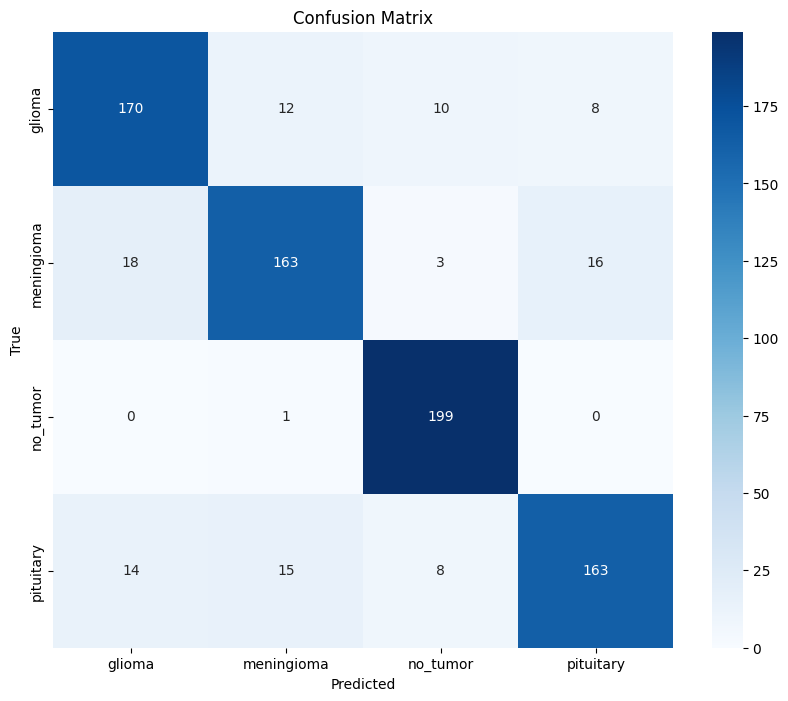

0.86875


In [37]:
accuracy, misclassified = get_accuracy_test(model, test_loader)
print(accuracy)

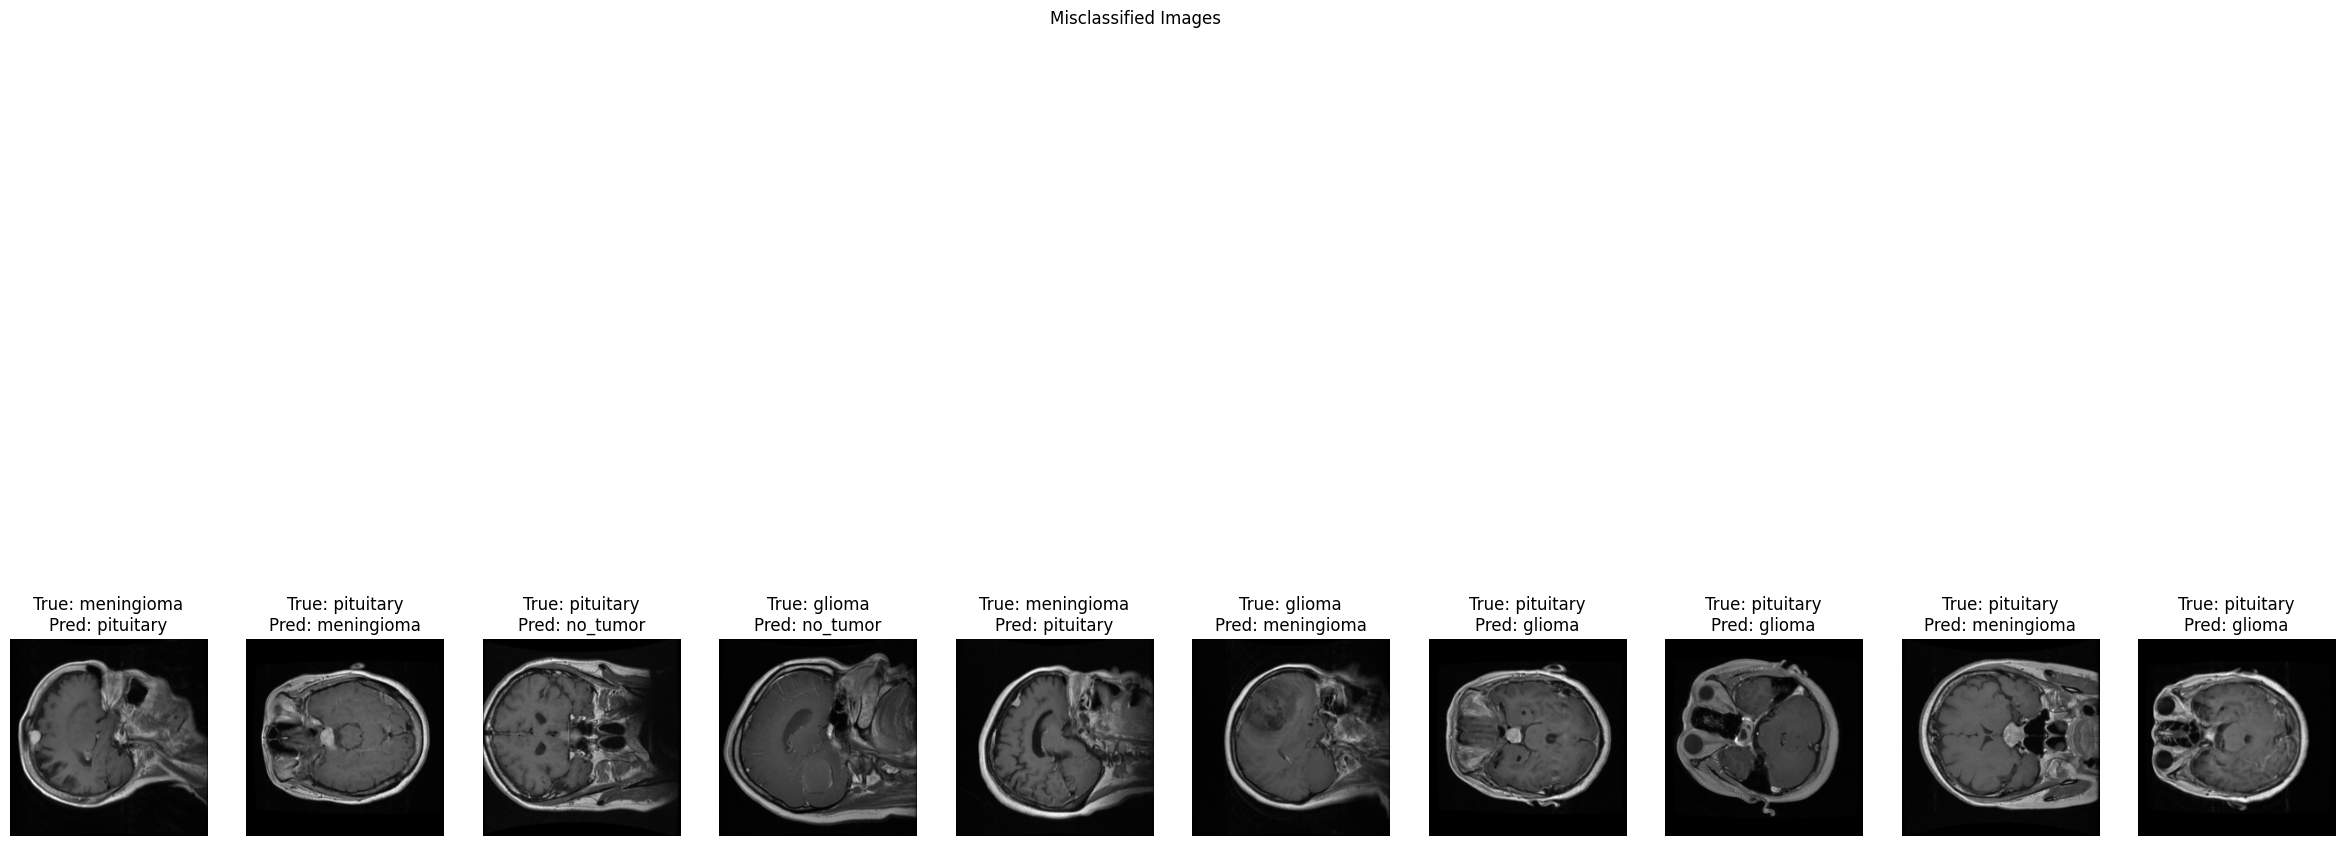

In [38]:
show_misclassified_images(misclassified, test_loader.dataset.classes)

In [27]:
!rm -rf /content/NewClassificationData
!rm -rf /content/NewClassificationData_ForTesting
!rm -rf /content/TruncatedClassificationData

SINGLE IMAGE TESTING

In [39]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((224, 224)),
                                transforms.Normalize((0.5), (0.5))
                                ])

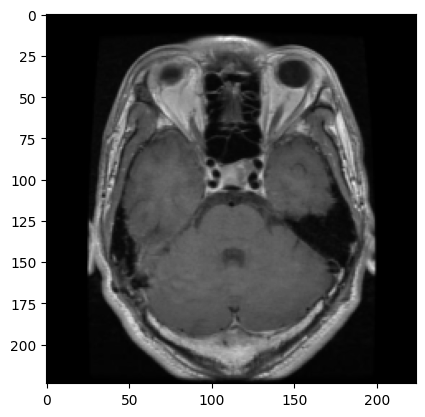

In [41]:
from PIL import Image

model.load_state_dict(torch.load('brain_tumor_model2.pth'))
model.eval()

image_path = '/content/Te-piTr_0000.jpg'  # Replace with the actual path
image = Image.open(image_path).convert('L')  # Convert to grayscale
image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [42]:
import torch.nn.functional as F

# Move the image and model to GPU if available
if use_cuda and torch.cuda.is_available():
    image = image.cuda()
    model = model.cuda()

with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

# Assuming class_names contains the class names in the correct order
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']  # Replace with actual class names if different

# Print the predicted class index and the class name
print('Predicted class index: ', predicted.item())
print('Predicted class name: ', class_names[predicted.item()])

# Calculate and print probabilities
with torch.no_grad():
    output = model(image)
    probabilities = F.softmax(output, dim=1)

for i, class_name in enumerate(class_names):
    print(f"Probability that image is {class_name}: ", probabilities[0, i].item())


Predicted class index:  3
Predicted class name:  pituitary
Probability that image is glioma:  1.2522162862182995e-08
Probability that image is meningioma:  5.020730895921588e-06
Probability that image is no tumor:  2.1859083987330052e-10
Probability that image is pituitary:  0.9999949932098389
